# Change Point Detection algorithms

Even Matencio - 17/04/2024

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import ruptures as rpt

import time
from timeit import timeit

from custom_cost_functions import MyL2Cost

### Some cost functions

In [9]:
def dummy_L2(signal):
    '''Returns the L2 cost of approximation by mean of the possibly multivariate input signal.

    Args: 
        signal (np.ndarray): of shape [n_samples, n_dim]
    '''
    return np.sum(np.var(signal, axis=0))*signal.shape[0]

### Search methods implementation

In [10]:
def naive_opt_cpd_dynprog(signal, cost_func, pen_val):
    ''' A naive version of the optimal partitioning algorithm described in 'Optimal Detection
    of Changepoints With a Linear Computational Cost, R. Killick' witout prunning and 
    per segment cost pre-computation. 
    
    DISCLAIMER: too expensive memory speaking, it is very frequently not possible
    to store [n_samples, n_samples] matrices.

    Args:
        signal (np.ndarray): of shape [n_samples, n_dim]
        cost_func func([np.ndarray], float): computes the approximation cost of the input sub-signal
        pen_val (float): penalty coefficient

    return:
        cps_per_t[-1] (List[int]): change points detected
        tot_costs[-1] (float): associated overall cost
    '''
    # Initialization
    n_samples = signal.shape[0]
    tot_costs = -pen_val * np.ones(n_samples+1)
    cps_per_t = [[]]
    # Dynamic programmation CPD without segment cost pre-computation
    for t in range(1, n_samples+1):
        # Compute all possible costs
        running_per_segment_cost = np.array(list(map(cost_func, [signal[s:t, :] for s in range(0, t)])))
        possible_running_costs =  tot_costs[:t] + running_per_segment_cost + pen_val
        # Extract the change-point (argmin) and store it
        cp = np.argmin(possible_running_costs)
        tot_costs[t] = possible_running_costs[cp]
        cps_per_t.append(cps_per_t[cp] + [cp])
    return cps_per_t[-1], tot_costs[-1]

In [11]:
def precomp_opt_cpd_dynprog(signal, cost_computor, pen_val):
    ''' The optimal partitioning algorithm described in 'Optimal Detection
    of Changepoints With a Linear Computational Cost, R. Killick' witout prunning.
    Computation tricks are leveraged to (pre-)compute the approximation costs per 
    segment of the input signal.

    Args:
        signal (np.ndarray): of shape [n_samples, n_dim]
        pen_val (float): penalty coefficient
        cost_computor (BaseCost)

    return:
        cps_per_t[-1] (List[int]): change points detected
        tot_costs[-1] (float): associated overall cost
    '''
    # Initialization
    n_samples = signal.shape[0]
    tot_costs = -pen_val * np.ones(n_samples+1)
    cps_per_t = [[]]
    # Pre-computation of the cost per segment
    cost_computor.fit(signal)
    # Dynamic programmation CPD
    for t in range(1, n_samples+1):
        # Compute all possible costs
        running_per_segment_cost = np.array([cost_computor.error(s, t) for s in range(t)])
        possible_running_costs =  tot_costs[:t] + running_per_segment_cost + pen_val
        # Extract the change-point (argmin) and store it
        cp = np.argmin(possible_running_costs)
        tot_costs[t] = possible_running_costs[cp]
        cps_per_t.append(cps_per_t[cp] + [cp])
    return cps_per_t[-1], tot_costs[-1]

In [12]:
def pelt_cpd(signal, cost_func, pen_val):
    ''' The PELT algoritm in 'Optimal Detection
    of Changepoints With a Linear Computational Cost, R. Killick' witout prunning and 
    per segment cost pre-computation. 

    Args:
        signal (np.ndarray): of shape [n_samples, n_dim]
        cost_func func([np.ndarray], float): computes the approximation cost of the input sub-signal
        pen_val (float): penalty coefficient

    return:
        cps_per_t[-1] (List[int]): change points detected
        tot_costs[-1] (float): associated overall cost
    '''
    # Initialization
    n_samples = signal.shape[0]
    tot_costs = -pen_val * np.ones(n_samples+1)
    cps_per_t = [[]]
    optim_set = [0] 
    # Dynamic programmation CPD without segment cost pre-computation
    for t in range(1, n_samples+1):
        # Compute all possible costs using pruning
        running_per_segment_cost = np.array(list(map(cost_func, [signal[s:t, :] for s in optim_set])))
        possible_running_costs =  tot_costs[np.array(optim_set)] + running_per_segment_cost + pen_val
        # Extract the index of the minimum in the optimal set
        cp_ind = np.argmin(possible_running_costs)
        tot_costs[t] = possible_running_costs[cp_ind]
        # Turn the index of the minimum into change point value
        running_indexes = np.arange(t)
        cp = running_indexes[np.array(optim_set)][cp_ind]
        cps_per_t.append(cps_per_t[cp] + [cp])
        # Update the optimization set
        optim_set = [s for ind, s in enumerate(optim_set) if (tot_costs[running_indexes[s]] + running_per_segment_cost[ind]) <= tot_costs[t]] + [t]
    return cps_per_t[-1], tot_costs[-1]

### Signal generation

In [13]:
n_samples = 100
n_dim = 5
n_bkps = 2
noise_std = 1
signal_seed = 2

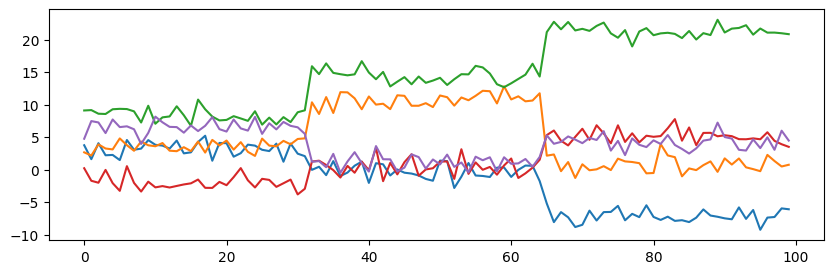

In [14]:
signal, bkps = rpt.pw_constant(n_samples, n_dim, n_bkps, noise_std=noise_std, seed=signal_seed)

fig, ax = plt.subplots(1, 1, figsize=(10, 3))
for i in range(n_dim):
    ax.plot(signal[:, i])
plt.show()

### Experiments

#### Basic comparison of the different methods

In [15]:
bic_L2_pen = n_dim/2 * np.log(n_samples)
L2_cost_computor = MyL2Cost()

pen = 2*bic_L2_pen
cps, cost = naive_opt_cpd_dynprog(signal, dummy_L2, pen)
cps2, cost2= precomp_opt_cpd_dynprog(signal, L2_cost_computor, pen)
cps3, cost3 = pelt_cpd(signal, dummy_L2, pen)
# cps4, cost4= pelt_cpd_precomp(signal, 'L2', pen)

In [16]:
print(bic_L2_pen)
print(cps, bkps)
print(cps2, bkps)
print(cps3, bkps)
# print(cps4, bkps)

11.51292546497023
[0, 32, 65] [32, 65, 100]
[0, 32, 65] [32, 65, 100]
[0, 32, 65] [32, 65, 100]


#### Model selection analysis: experiments on the penalty coefficient

In [18]:
print(f"n_samples={n_samples}, n_dim={n_dim}, n_bkps={n_bkps}, std_noise={noise_std} \n")

L2_cost_computor = MyL2Cost()
pen_vals = [0, 0.01, 0.1, 1, 5, 10, 20, 50, 100]
for pen_val in pen_vals:
    # cps, cost = naive_opt_cpd_dynprog(signal, dummy_L2, pen_val)
    # cps, cost = precomp_opt_cpd_dynprog(signal, L2_cost_computor, pen_val)
    cps, cost = pelt_cpd(signal, dummy_L2, pen_val)
    # cps, cost = pelt_cpd_precomp(signal, 'L2', pen_val)
    pev_val_str = str(pen_val) + '   ' 
    print(f"For B={pev_val_str[:4]}: \t bkps = {bkps[:-1]} ;  cps = {cps[1:]}")

n_samples=100, n_dim=5, n_bkps=2, std_noise=1 

For B=0   : 	 bkps = [32, 65] ;  cps = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
For B=0.01: 	 bkps = [32, 65] ;  cps = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
For B=0.1 : 	 bkps = [32, 65] ;  cps = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,

#### Time complexity evaluation

In [13]:
nb_it = 100
total_time_naive = timeit("naive_opt_cpd_dynprog(signal, dummy_L2, pen)", number=nb_it, globals=globals())
total_time_precomp = timeit("precomp_opt_cpd_dynprog(signal, L2_cost_computor, pen)", number=nb_it, globals=globals())
total_time_pelt = timeit("pelt_cpd(signal, dummy_L2, pen)", number=nb_it, globals=globals())
# total_time_pelt_precomp = timeit("pelt_cpd_precomp(signal, 'L2', pen)", number=nb_it, globals=globals())

print(f"Naive method: \t \t \t total time over {nb_it} iterations is {total_time_naive:.2f}s. Average time is {total_time_naive/nb_it:.2f}s")
print(f"With pre-computation: \t \t total time over {nb_it} iterations is {total_time_precomp:.2f}s. Average time is {total_time_precomp/nb_it:.2f}s")
print(f"With PELT : \t \t \t total time over {nb_it} iterations is {total_time_pelt:.2f}s. Average time is {total_time_pelt/nb_it:.2f}s")
# print(f"With PELT and pre-computation: \t total time over {nb_it} iterations is {total_time_pelt_precomp:.2f}s. Average time is {total_time_pelt_precomp/nb_it:.2f}s")

Naive method: 	 	 	 total time over 100 iterations is 18.09s. Average time is 0.18s
With pre-computation: 	 	 total time over 100 iterations is 5.80s. Average time is 0.06s
With PELT : 	 	 	 total time over 100 iterations is 8.25s. Average time is 0.08s


For n_samples=10  : 	 bkps = [] ;  naive_cps = [] ; pre_comp_cps = [] ; PELT = []
For n_samples=50  : 	 bkps = [] ;  naive_cps = [] ; pre_comp_cps = [] ; PELT = []
For n_samples=100 : 	 bkps = [50] ;  naive_cps = [50] ; pre_comp_cps = [50] ; PELT = [50]
For n_samples=200 : 	 bkps = [65, 130] ;  naive_cps = [65, 130] ; pre_comp_cps = [65, 130] ; PELT = [65, 130]
For n_samples=400 : 	 bkps = [79, 156, 242, 320] ;  naive_cps = [79, 156, 242, 320] ; pre_comp_cps = [79, 156, 242, 320] ; PELT = [79, 156, 242, 320]
For n_samples=800 : 	 bkps = [87, 172, 269, 354, 443, 535, 620, 710] ;  naive_cps = [87, 172, 269, 354, 443, 535, 620, 710] ; pre_comp_cps = [87, 172, 269, 354, 443, 535, 620, 710] ; PELT = [87, 172, 269, 354, 443, 535, 620, 710]
For n_samples=1600: 	 bkps = [92, 180, 287, 375, 469, 568, 656, 751, 847, 939, 1037, 1131, 1214, 1324, 1401, 1499] ;  naive_cps = [92, 180, 287, 375, 469, 568, 656, 751, 847, 939, 1037, 1131, 1214, 1324, 1401, 1499] ; pre_comp_cps = [92, 180, 287, 375, 469

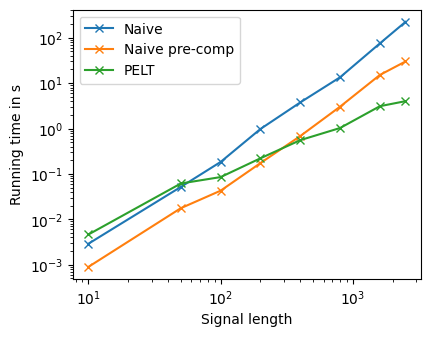

In [15]:
n_samples_l = [10, 50, 100, 200, 400, 800, 1600, 2500] 
naive_times = []
pre_compt_times = []
pelt_times = []
pelt_precompt_times = []

for n_samples in n_samples_l:
    n_dim = 5
    noise_std = 1
    signal_seed = 2 
    n_bkps = n_samples // 100
    bic_L2_pen = n_dim/2 * np.log(n_samples)
    pen = 2 * bic_L2_pen
    signal, bkps = rpt.pw_constant(n_samples, n_dim, n_bkps, noise_std=noise_std, seed=signal_seed)
    # Naive method
    t1 = time.perf_counter()
    cps_naive, cost = naive_opt_cpd_dynprog(signal, dummy_L2, pen)
    t2 = time.perf_counter()
    naive_times.append(t2 - t1)
    # With pre-computation
    t1 = time.perf_counter()
    cps_pre_comp, cost = precomp_opt_cpd_dynprog(signal, L2_cost_computor, pen)
    t2 = time.perf_counter()
    pre_compt_times.append(t2 - t1)
    # PELT method
    t1 = time.perf_counter()
    cps_pelt, cost = pelt_cpd(signal, dummy_L2, pen)
    t2 = time.perf_counter()
    pelt_times.append(t2 - t1)
    # With pre-computation
    t1 = time.perf_counter()
    # cps_pelt_pre_comp, cost = pelt_cpd_precomp(signal, 'L2', pen)
    # t2 = time.perf_counter()
    # pelt_precompt_times.append(t2 - t1)
    # Checking results
    n_smpl_str = str(n_samples) + '   ' 
    print(f"For n_samples={n_smpl_str[:4]}: \t bkps = {bkps[:-1]} ;  naive_cps = {cps_naive[1:]} ; pre_comp_cps = {cps_pre_comp[1:]} ; PELT = {cps_pelt[1:]}")

fig, ax = plt.subplots(1, 1, figsize=(4.5, 3.5))
ax.plot(n_samples_l, naive_times, marker='x', label='Naive')
ax.plot(n_samples_l, pre_compt_times, marker='x', label='Naive pre-comp')
ax.plot(n_samples_l, pelt_times, marker='x', label='PELT')
# ax.plot(n_samples_l, pelt_precompt_times, marker='x', label='PELT pre-comp')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel("Signal length")
ax.set_ylabel("Running time in s")
ax.legend()
plt.show()

#### Using Ruptures algorithms

In [19]:
def compute_overall_L2cost(signal, bkps, pen):
    """ Returns the overall detection L2 cost for a given signal, 
    given change points and given penalty coefficient.
    For testing purpose only.
    Relies on three different computations.

    Args:
        signal (np.ndarray): signal of shape [n_samples, n_dim]
        bkps (List[int]): time indexes of the change points. 
        pen (float): changing point penaly coefficient.
    return:
        overall_cost (float): the overall change point detection cost
    """
    cost_comp = rpt.costs.CostL2().fit(signal)
    n_samples = signal.shape[0]
    my_overall_cost = -pen
    rpt_overall_cost = -pen
    # Initialization
    if bkps[0] != 0:
        bkps = [0] + bkps
    if bkps[-1] != n_samples:
        bkps = bkps + [n_samples]
    # Cost computation
    for i in range(len(bkps[:-1])):
        my_overall_cost += pen + dummy_L2(signal[bkps[i]:bkps[i+1], :])
        rpt_overall_cost += pen + cost_comp.error(bkps[i], bkps[i+1])
    return my_overall_cost, rpt_overall_cost, cost_comp.sum_of_costs(bkps[1:]) + len(bkps[1:-1])*pen


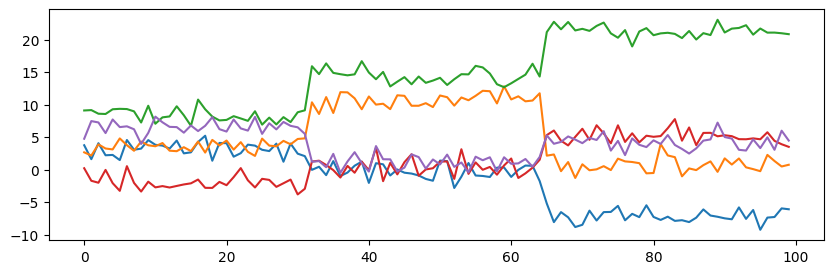

In [36]:
n_samples = 100
n_dim = 5
n_bkps = 2
noise_std = 1
signal_seed = 2

signal, bkps = rpt.pw_constant(n_samples, n_dim, n_bkps, noise_std=noise_std, seed=signal_seed)

fig, ax = plt.subplots(1, 1, figsize=(10, 3))
for i in range(n_dim):
    ax.plot(signal[:, i])
plt.show()

In [41]:
bic_L2_pen = n_dim/2 * np.log(n_samples)
pen = 2 * bic_L2_pen

# PELT algorithm from RUPTURES and custom L2 cost
algo_myl2 = rpt.Pelt(custom_cost=MyL2Cost()).fit(signal)
rpt_bkps = algo_myl2.predict(pen=pen)

# PELT algorithm from RUPTURES and L2 cost from RUPTURES
algo_rptl2 = rpt.Pelt(model='l2').fit(signal)
rpt_l2rpt_bkps = algo_rptl2.predict(pen=pen)

# custom PELT algorithm and custom L2 cost
pre_comp_bkps, pre_comp_cost = precomp_opt_cpd_dynprog(signal, MyL2Cost(), pen)

# custom PELT algorithm and dummy L2 cost
pelt_bkps, pelt_cost = pelt_cpd(signal, dummy_L2, pen)

print("GROUNDTRUTH: \t \t", bkps, "\t\t ---> cost=", compute_overall_L2cost(signal, bkps, pen))
print("RPT PELT & MyL2: \t", rpt_bkps, "\t ---> cost=", compute_overall_L2cost(signal, rpt_bkps, pen))
print("RPT PELT & RptL2 : \t", rpt_l2rpt_bkps, "\t ---> cost=", compute_overall_L2cost(signal, rpt_l2rpt_bkps, pen))
print("MY precomp & MyL2: \t", pre_comp_bkps, "\t\t ---> cost=", compute_overall_L2cost(signal, pre_comp_bkps, pen))
print("MY PELT & MyL2: \t", pelt_bkps, "\t\t ---> cost=", compute_overall_L2cost(signal, pelt_bkps, pen))

GROUNDTRUTH: 	 	 [32, 65, 100] 		 ---> cost= (546.9816326743044, 546.9816326743044, 546.9816326743044)
RPT PELT & MyL2: 	 [30, 35, 65, 100] 	 ---> cost= (700.0991294984427, 700.0991294984427, 700.0991294984427)
RPT PELT & RptL2 : 	 [30, 35, 65, 100] 	 ---> cost= (700.0991294984427, 700.0991294984427, 700.0991294984427)
MY precomp & MyL2: 	 [0, 32, 65] 		 ---> cost= (546.9816326743044, 546.9816326743044, 546.9816326743044)
MY PELT & MyL2: 	 [0, 32, 65] 		 ---> cost= (546.9816326743044, 546.9816326743044, 546.9816326743044)


In [22]:
print(pre_comp_cost)
print(pelt_cost)

546.9816326742854
546.9816326743044


## GFSS implementation 

In [23]:
import networkx as nx
from scipy.linalg import eigh

from ruptures.base import BaseCost

### Cost class

In [24]:
class GFSSL2Cost(BaseCost):

    """
    Applies the GFSS rotation to the whole signal before computing
    the standard L2 cost for fixed variance gaussian hypothesis.
    """

    model = "gfss_l2_cost"
    min_size = 1

    def __init__(self, graph, cut_sparsity) -> None:
        self.cut_sparsity = cut_sparsity
        self.graph = graph
        self.signal = None
        self.gft_square_cumsum = None
        self.gft_cumsum = None
        super().__init__()

    def filter(self, freqs, eps=0.00001):
        """Applies the GFSS filter to the input (spatial) frequences.

        Args:
            freqs (np.ndarray): frequences to filter.
            eps (float, optional): threshold for non zero values. Defaults to 0.00001.

        Returns:
            filtered_freqs (np.ndarray): the output of the filter.
        """
        nb_zeros = np.sum(freqs < eps)
        filtered_freqs = np.minimum(1, np.sqrt(self.cut_sparsity / freqs[nb_zeros:]))
        return np.concatenate([np.zeros(nb_zeros), filtered_freqs])
    
    def fit(self, signal):
        """Performs pre-computations for per-segment approximation cost.

        Args:
            signal (np.ndarray): of shape [n_samples, n_dim]
        """
        self.signal = signal
        # Computation of the GFSS
        eigvals, eigvects = eigh(nx.laplacian_matrix(self.graph).toarray())
        filter_matrix = np.diag(self.filter(eigvals), k=0)
        gft = filter_matrix.dot(eigvects.T.dot(signal.T)).T
        # Computation of the per-segment cost utils
        self.gft_square_cumsum =  np.concatenate([np.zeros((1, signal.shape[1])), np.cumsum(gft**2, axis=0)], axis=0)
        self.gft_cumsum =  np.concatenate([np.zeros((1, signal.shape[1])), np.cumsum(gft, axis=0)], axis=0)
        return self

    def error(self, start, end):
        """Return the L2 approximation cost on the segment [start:end] 
        where end is excluded.

        Args:
            start (int): start of the segment
            end (int): end of the segment

        Returns:
            float: segment cost
        """
        if end - start < self.min_size:
            raise ValueError(f'end - start shoud be higher than {self.min_size}')
        
        sub_square_sum = self.gft_square_cumsum[end] - self.gft_square_cumsum[start]
        sub_sum = self.gft_cumsum[end] - self.gft_cumsum[start]
        return np.sum(sub_square_sum - (sub_sum**2) / (end  - start))  


### Graph and signal generation

In [25]:
nb_nodes = 30
cluster_nb = 3
mean_cluster_size = 12
inter_density = 0.05
intra_density = 0.85
graph_seed = 10

G = nx.gaussian_random_partition_graph(n=nb_nodes, s=mean_cluster_size, v=2*mean_cluster_size, p_in=intra_density, p_out=inter_density, seed=graph_seed)

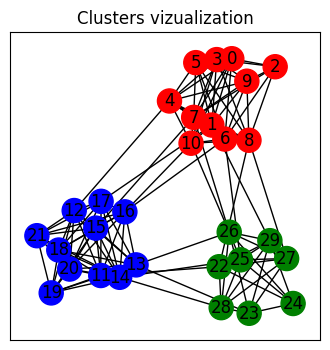

In [26]:
# Vizualization of the graph clusters
#####################################

clusters_seed = 20
clusters = nx.algorithms.community.louvain.louvain_communities(G, seed=clusters_seed)
colors_dct = {0: 'r', 1: 'b', 2: 'g'}
cluster_idx_arr = np.zeros((nb_nodes))

for cl_ind in range(len(clusters)):
    for node_ind in list(clusters[cl_ind]):
        cluster_idx_arr[node_ind] = cl_ind

colors_l = [colors_dct[cluster_idx_arr[node_ind]] for node_ind in range(nb_nodes)]

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.set_title('Clusters vizualization')
nx.draw_networkx(G, with_labels=True, node_color=colors_l,  ax=ax)

Text(0.5, 0.98, 'Eigenvectors vizualization')

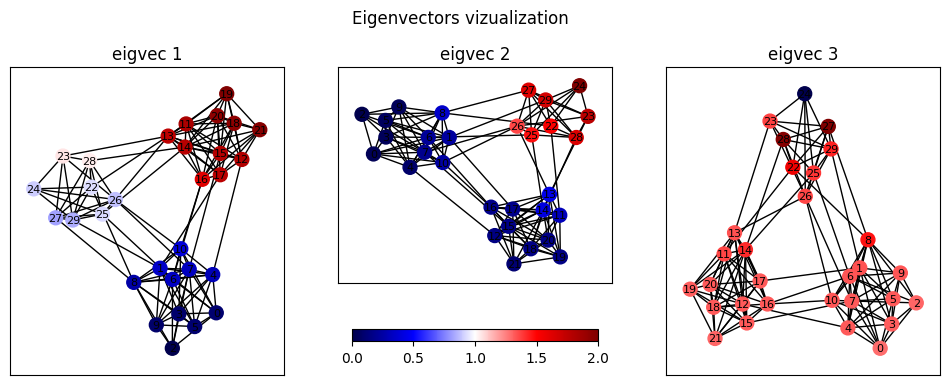

In [27]:
# Vizualization of the eigenvectors shapes
##########################################

import matplotlib

eigvals, eigvects = eigh(nx.laplacian_matrix(G).toarray())
norm = lambda arr: (arr - np.min(arr))/(np.max(arr) - np.min(arr))

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
nx.draw_networkx(G, with_labels=True, node_color=norm(eigvects[:, 1]), node_size=100, font_size=8, cmap='seismic', ax=axes[0])
axes[0].set_title(f'eigvec 1')
nx.draw_networkx(G, with_labels=True, node_color=norm(eigvects[:, 2]), node_size=100, font_size=8, cmap='seismic', ax=axes[1])
axes[1].set_title(f'eigvec 2')
nx.draw_networkx(G, with_labels=True, node_color=norm(eigvects[:, 3]), node_size=100, font_size=8, cmap='seismic', ax=axes[2])
axes[2].set_title(f'eigvec 3')
fig.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=0, vmax=2), cmap='seismic'), shrink=0.9, ax=axes[1], orientation='horizontal')
fig.suptitle('Eigenvectors vizualization', verticalalignment='bottom')

In [28]:
n_dim_no_change = sum([len(cl) for cl in clusters[:-1]])
n_dim_with_change = len(clusters[-1])
n_dim = n_dim_no_change + n_dim_with_change
n_samples = 100
noise_std = 1
signal_seed = 10

signal_no_change, _ = rpt.pw_constant(n_samples, n_dim_no_change, 0, noise_std=noise_std, seed=signal_seed)
signal_with_change, bkps = rpt.pw_constant(n_samples, n_dim_with_change, 1, noise_std=noise_std, seed=signal_seed)
signal = np.concatenate([signal_no_change, signal_with_change], axis=1)

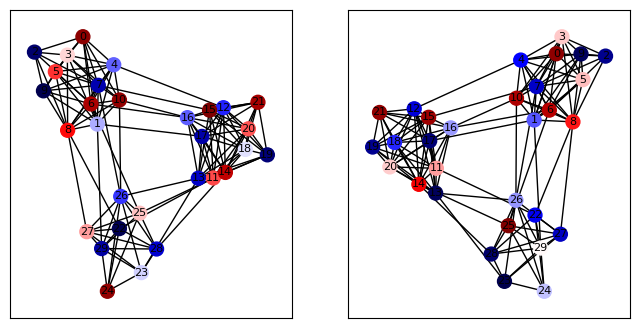

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
nx.draw_networkx(G, with_labels=True, node_color=signal[bkps[0]-10, :], node_size=100, font_size=8, cmap='seismic', ax=axes[0])
nx.draw_networkx(G, with_labels=True, node_color=signal[bkps[0]+10, :], node_size=100, font_size=8, cmap='seismic', ax=axes[1])

### Experiments

In [31]:
bic_L2_pen = n_dim/2 * np.log(n_samples)
pen = 2* bic_L2_pen

#  WITHOUT GRAPH STRUCTURE
algo = rpt.Pelt(model='l2').fit(signal)
my_bkps = algo.predict(pen=pen)
print("WITHOUT GRAPH: ", bkps, my_bkps)

#  WITH GRAPH STRUCTURE
graph_algo = rpt.Pelt(custom_cost=GFSSL2Cost(G, 2)).fit(signal)
my_graph_bkps = graph_algo.predict(pen=pen)
print("WITH GRAPH: ", bkps, my_graph_bkps)

WITHOUT GRAPH:  [49, 100] [50, 100]
WITH GRAPH:  [49, 100] [50, 100]


In [33]:
noise_std_values = [0.1, 1, 2, 3, 4]

n_dim_no_change = sum([len(cl) for cl in clusters[:-1]])
n_dim_with_change = len(clusters[-1])
n_dim = n_dim_no_change + n_dim_with_change
n_samples = 100
signal_seed = 10

bic_L2_pen = n_dim/2 * np.log(n_samples)
pen = 2* bic_L2_pen

for noise_std in noise_std_values:
    
    signal_no_change, _ = rpt.pw_constant(n_samples, n_dim_no_change, 0, noise_std=noise_std, seed=signal_seed)
    signal_with_change, gt_bkps = rpt.pw_constant(n_samples, n_dim_with_change, 1, noise_std=noise_std, seed=signal_seed)
    signal = np.concatenate([signal_no_change, signal_with_change], axis=1)

    # WITH DYN PROD WITHOUT PELT AND WITH GRAPH
    pre_comp_bkps, pre_comp_cost = precomp_opt_cpd_dynprog(signal, GFSSL2Cost(G, 1), pen)

    #  WITHOUT GRAPH STRUCTURE
    algo = rpt.Pelt(model='l2').fit(signal)
    my_bkps = algo.predict(pen=pen)

    #  WITH GRAPH STRUCTURE
    graph_algo = rpt.Pelt(custom_cost=GFSSL2Cost(G, 1)).fit(signal)
    my_graph_bkps = graph_algo.predict(pen=pen)
    
    print("NOISE_STD=", noise_std, "\tGROUNDTRUTH", bkps, "\tPRE-COMP WITH GRAPH:", pre_comp_bkps, "\t WITH GRAPH: ", my_graph_bkps, "\tWITHOUT GRAPH: ",  my_bkps)


NOISE_STD= 0.1 	GROUNDTRUTH [49, 100] 	PRE-COMP WITH GRAPH [0, 49] 	 WITH GRAPH:  [50, 100] 	WITHOUT GRAPH:  [50, 100]
NOISE_STD= 1 	GROUNDTRUTH [49, 100] 	PRE-COMP WITH GRAPH [0, 49] 	 WITH GRAPH:  [50, 100] 	WITHOUT GRAPH:  [50, 100]
NOISE_STD= 2 	GROUNDTRUTH [49, 100] 	PRE-COMP WITH GRAPH [0, 49] 	 WITH GRAPH:  [50, 100] 	WITHOUT GRAPH:  [15, 30, 40, 45, 50, 55, 90, 95, 100]
NOISE_STD= 3 	GROUNDTRUTH [49, 100] 	PRE-COMP WITH GRAPH [0, 49] 	 WITH GRAPH:  [50, 100] 	WITHOUT GRAPH:  [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 90, 95, 100]
NOISE_STD= 4 	GROUNDTRUTH [49, 100] 	PRE-COMP WITH GRAPH [0, 18, 19, 49] 	 WITH GRAPH:  [50, 100] 	WITHOUT GRAPH:  [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]


## DRAFT

In [ ]:
# def pelt_cpd_precomp(signal, cost_computor, pen_val):
#     ''' 
#     The PELT algorithm described in 'Optimal Detection
#     of Changepoints With a Linear Computational Cost, R. Killick'.
#     Computation tricks are leveraged to (pre-)compute the approximation costs per 
#     segment of the input signal.

#     args:
#         signal: (np.ndarray) of shape [n_samples, n_dim]
#         pen_val: (float) penalty coefficient
#         cost_computor: (BaseCost)

#     return:
#         cps_per_t[-1]: (List[int]) change points detected
#         tot_costs[-1]: (float) associated overall cost
#     '''
#     # Initialization
#     n_samples = signal.shape[0]
#     tot_costs = -pen_val * np.ones(n_samples+1)
#     cps_per_t = [[]]
#     optim_set = [0]
#     # Pre-computation of the cost per segment
#     cost_computor.fit(signal)
#     # Dynamic programmation CPD
#     for t in range(1, n_samples+1):
#         running_per_segment_cost = np.array([cost_computor.error(s, t) for s in range(t)])
#         possible_running_costs =  tot_costs[:t] + running_per_segment_cost + pen_val
#         running_indexes = np.arange(t)
#         cp_ind = np.argmin(possible_running_costs[np.array(optim_set)])
#         cp = running_indexes[np.array(optim_set)][cp_ind]
#         tot_costs[t] = possible_running_costs[cp]
#         cps_per_t.append(cps_per_t[cp] + [cp])
#         optim_set = [s for s in optim_set if (tot_costs[s] + running_per_segment_cost[s]) <= tot_costs[t]] + [t]
#     return cps_per_t[-1], tot_costs[-1]